#### Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import category_encoders as ce

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
%matplotlib inline

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы

RANDOM_SEED = 42

# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы

#!pip3 freeze > requirements.txt

#### Загружаем данные

In [3]:
# загружаем данные

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [4]:
# познакомимся с датасетом для обучения

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
# познакомимся с датасетом для предсказания

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [6]:
# познакомимся с сабмишном

sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [7]:
# для корректной обработки признаков объединим датасет для обучения и датасет для предсказания в один датасет data
# в тестовом датафрейме отсутствует признак reviewer_score так что заполняем его нулями
# создадим признак sample, который будет содержать 1 для данных из датасета для обучения и 0 для данных из датасета для предсказания

df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = pd.concat([df_train, df_test], ignore_index = True)

In [8]:
# познакомимся с получившимся датасетом

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [9]:
# в признаках lat и lng имеются пропуски

data[(data.lng.isna()) | (data.lat.isna())].shape[0] 

3268

#### Поработаем со строковыми значениями

#### Извлечем несколько признаков из адреса отеля

In [10]:
# извлекаем признак страны из адреса
# попутно поработаем с названием Англии, в датасете она именуется как Kingdom, переименуем ее в United Kingdom
# выведем количество стран в датасете

data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['hotel_country'] = data['hotel_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
display(data['hotel_country'].value_counts())

hotel_country
United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: count, dtype: int64

##### Получается, что отели расположены в шести странах

In [11]:
# извлекаем признак города из адреса
# попутно поработаем с Англией, в датасете город именуется как United, переименуем в London
# выведем количество городов в датасете

data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])
data['hotel_city'] = data['hotel_city'].apply(lambda x: 'London' if x == 'United' else x)
display(data['hotel_city'].value_counts())

hotel_city
London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: count, dtype: int64

##### Получается, что отели расположены в шести городах

#### После того, как определили города нахождения отелей, можно поработать с пропусками в признаках lat и lng

In [12]:
# заполним пропуски нулями с целью последующей обработки
values = {
    'lat': 0,
    'lng': 0,
}
data = data.fillna(values)

# заполним координаты географической широты отеля релеватными координатами города, в котором находится отель
def lat_fillna(x):
    lat = x[0]
    city = x[1]
    if city == 'Paris' and lat == 0:
        return 48.8567
    elif city == 'Vienna' and lat == 0:
        return 48.2000
    elif city == 'Barcelona' and lat == 0:
        return 41.3833
    elif city == 'London' and lat == 0:
        return 51.5072
    elif city == 'Milan' and lat == 0:
        return 45.4666
    elif city == 'Amsterdam' and lat == 0:
        return 52.3666
    else:
        return lat
    
data['lat'] = data[['lat', 'hotel_city']].apply(lat_fillna, axis = 1)

# заполним координаты географической долготы отеля релеватными координатами города, в котором находится отель
def lng_fillna(x):
    lng = x[0]
    city = x[1]
    if city == 'Paris' and lng == 0:
        return 2.3508
    elif city == 'Vienna' and lng == 0:
        return 16.3666
    elif city == 'Barcelona' and lng == 0:
        return 2.1833
    elif city == 'London' and lng == 0:
        return 0.1275
    elif city == 'Milan' and lng == 0:
        return 9.1833
    elif city == 'Amsterdam' and lng == 0:
        return 4.9000
    else:
        return lng
    
data['lng'] = data[['lng', 'hotel_city']].apply(lng_fillna, axis = 1)

In [13]:
# убедимся, что пропусков больше нет

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

#### Закодируем получившиеся признаки страны и города с помощью метода OneHotEncoding

In [14]:
# кодируем признак страны

encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

# кодируем признак города

encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

#### Добавим в датасет население страны и население города, а также долю населения города к населению страны

In [15]:
country_population = {
    'United Kingdom':68481129,'Netherlands':17198147,'France':65515838,
    'Spain':46785044,'Italy':60313823,'Austria':9093258
}
data['country_population'] = data['hotel_country'].map(country_population)

сity_population = {
    'Paris': 2139907, 'London': 9002488, 'Milan': 1374582,
    'Vienna': 1951354, 'Barcelona': 1636732, 'Amsterdam': 905234
}

data['сity_population'] = data['hotel_city'].map(сity_population)

data['%_city_pop_from_country_pop'] = data['сity_population'] / data['country_population']

#### Поработаем с датой

In [16]:
# извлекаем месяц из даты отзыва

data['review_date'] = pd.to_datetime(data['review_date'])  
data['review_date_month'] = data['review_date'].dt.month.astype(int)

# извлекаем количество дней между датой проверки и датой очистки и преобразовываем к числовому типу данных

data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')

#### Поработаем с признаком reviewer_nationality

In [17]:
# посмотрим, сколько всего уникальных значений

print(len(data['reviewer_nationality'].unique()))

227


In [18]:
# определим Топ-10 остальные определим как Other

top_ten_nationalities= data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_ten_nationalities else 'Other')

display(data['reviewer_nationality'].head(5))

0     United Kingdom 
1     United Kingdom 
2               Other
3     United Kingdom 
4               Other
Name: reviewer_nationality, dtype: object

In [19]:
# закодируем признак reviewer_nationality с помощью метода LabelEncoder

data['reviewer_nationality'] = LabelEncoder().fit_transform(data['reviewer_nationality'])

#### Поработаем с тегами

In [20]:
# функция для создания словаря с подсчетом тегов

unique_dic = {}
def make_unique_dic(x):
    x = x[3:-3].split(" ', ' ")
    for elem in x:
        if elem in unique_dic:
            unique_dic[elem] = unique_dic[elem] + 1
        else:
            unique_dic[elem] = 1
    return x

data['tags'].apply(make_unique_dic)

# получим датафрейм со всеми тегами и их частотой встречаемости

unique_tags = pd.DataFrame(unique_dic, index=['count']).transpose()
display(unique_tags)

,count
Leisure trip,417778
Couple,252294
Studio Suite,728
Stayed 2 nights,133937
Submitted from a mobile device,307640
...,...
Shoreditch Suite,1
Suite Champs lys es,1
Special Offer Room with Continental Breakfast,1
Original Double Room,1


In [21]:
# преобразуем строки тегов в списки тегов

data.tags = data.tags.apply(lambda x: x[3:-3].split(" ', ' "))
data['tags'].head(3)

0    [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1    [Business trip, Couple, Standard Double Room, ...
2    [Leisure trip, Solo traveler, Modern Double Ro...
Name: tags, dtype: object

In [22]:
# определим Топ-20

top_tags = list(unique_tags.index[:20])
print(top_tags)

['Leisure trip', 'Couple', 'Studio Suite', 'Stayed 2 nights', 'Submitted from a mobile device', 'Business trip', 'Standard Double Room', 'Stayed 1 night', 'Solo traveler', 'Modern Double Room Echo', 'Stayed 3 nights', 'Standard Room with 1 Double Bed', 'Standard Double or Twin Room', 'Stayed 6 nights', 'Superior Twin Room', 'Double Room Non Smoking', 'Superior Double Room', 'Stayed 4 nights', 'Double Room', 'Twin Hilton Guest Room']


In [23]:
# закодируем признак tags

for tag in top_tags:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

#### Работа с текстовыми полями с отзывами

In [24]:
# добавим признаки доля позитивных слов в общем количестве слов в отзыве и доля негативных слов в общем количестве слов в отзыве

data['%_positive_words_in_review'] = data['review_total_positive_word_counts'] / (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])
data['%_negative_words_in_review'] = data['review_total_negative_word_counts'] / (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])

In [25]:
# добавим признаки доля позитивных слов в расчете на один отзыв и доля негативных слов в расчете на один отзыв

data['%_positive_words_per_review'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
data['%_negative_words_per_review'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews_reviewer_has_given']

In [26]:
data.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Superior Twin Room,Double Room Non Smoking,Superior Double Room,Stayed 4 nights,Double Room,Twin Hilton Guest Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,8,Leaving,3,1994,Staff were amazing,...,0,0,0,0,0,0,0.571429,0.428571,0.571429,0.428571
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,8,poor breakfast,3,1361,location,...,0,0,0,0,0,0,0.400000,0.600000,0.142857,0.214286
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,10,No kettle in room,6,406,No Positive,...,0,0,0,0,0,0,0.000000,1.000000,0.000000,0.428571
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,8,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,0,0,0,0,0,1.000000,0.000000,1.375000,0.000000
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,10,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,0,0,0,0,0,0,0.833333,0.166667,2.000000,0.400000


##### Проверим созданные признаки на пустые значения

In [27]:
data[data['%_positive_words_in_review'].isna()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Superior Twin Room,Double Room Non Smoking,Superior Double Room,Stayed 4 nights,Double Room,Twin Hilton Guest Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review
2387,101 Buckingham Palace Road Westminster Borough...,838,2017-03-12,8.4,The Grosvenor,2,No Negative,0,3274,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
4396,10 Pepys Street City of London London EC3N 2NR...,215,2016-08-05,8.6,Novotel London Tower Bridge,10,No Negative,0,1082,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
5958,Pla a Urquinaona 2 Eixample 08010 Barcelona Spain,205,2017-04-19,9.1,H10 Urquinaona Plaza,8,No Negative,0,1875,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
8130,Vijzelstraat 4 Amsterdam City Center 1017 HK A...,589,2016-12-05,7.0,NH Carlton Amsterdam,10,No Negative,0,4231,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
11452,Pelayo 14 Ciutat Vella 08001 Barcelona Spain,72,2017-06-15,9.2,Hotel Midmost,5,No Negative,0,460,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506125,12 Osborn Street Aldgate East Tower Hamlets Lo...,404,2015-12-20,8.9,Arbor City,8,No Negative,0,2197,No Positive,...,0,0,1,0,0,0,NaN,NaN,0.0,0.0
507357,52 Chiswell Street City of London London EC1Y ...,704,2016-03-03,8.8,The Montcalm At Brewery London City,8,No Negative,0,2617,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
507724,Via Santo Spirito 20 Milan City Center 20121 M...,108,2015-11-12,9.2,Hotel Manzoni,6,No Negative,0,956,No Positive,...,0,0,0,1,0,0,NaN,NaN,0.0,0.0
511451,225 Edgware Road Westminster Borough London W2...,1485,2017-01-11,7.5,Hilton London Metropole,10,No Negative,0,6977,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0


In [28]:
data[data['%_negative_words_in_review'].isna()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Superior Twin Room,Double Room Non Smoking,Superior Double Room,Stayed 4 nights,Double Room,Twin Hilton Guest Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review
2387,101 Buckingham Palace Road Westminster Borough...,838,2017-03-12,8.4,The Grosvenor,2,No Negative,0,3274,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
4396,10 Pepys Street City of London London EC3N 2NR...,215,2016-08-05,8.6,Novotel London Tower Bridge,10,No Negative,0,1082,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
5958,Pla a Urquinaona 2 Eixample 08010 Barcelona Spain,205,2017-04-19,9.1,H10 Urquinaona Plaza,8,No Negative,0,1875,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
8130,Vijzelstraat 4 Amsterdam City Center 1017 HK A...,589,2016-12-05,7.0,NH Carlton Amsterdam,10,No Negative,0,4231,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
11452,Pelayo 14 Ciutat Vella 08001 Barcelona Spain,72,2017-06-15,9.2,Hotel Midmost,5,No Negative,0,460,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506125,12 Osborn Street Aldgate East Tower Hamlets Lo...,404,2015-12-20,8.9,Arbor City,8,No Negative,0,2197,No Positive,...,0,0,1,0,0,0,NaN,NaN,0.0,0.0
507357,52 Chiswell Street City of London London EC1Y ...,704,2016-03-03,8.8,The Montcalm At Brewery London City,8,No Negative,0,2617,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0
507724,Via Santo Spirito 20 Milan City Center 20121 M...,108,2015-11-12,9.2,Hotel Manzoni,6,No Negative,0,956,No Positive,...,0,0,0,1,0,0,NaN,NaN,0.0,0.0
511451,225 Edgware Road Westminster Borough London W2...,1485,2017-01-11,7.5,Hilton London Metropole,10,No Negative,0,6977,No Positive,...,0,0,0,0,0,0,NaN,NaN,0.0,0.0


In [29]:
data[data['%_positive_words_per_review'].isna()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Superior Twin Room,Double Room Non Smoking,Superior Double Room,Stayed 4 nights,Double Room,Twin Hilton Guest Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review


In [30]:
data[data['%_negative_words_per_review'].isna()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Superior Twin Room,Double Room Non Smoking,Superior Double Room,Stayed 4 nights,Double Room,Twin Hilton Guest Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review


In [31]:
# заполним пропуски медианными значениями

values = {
    '%_positive_words_in_review': data['%_positive_words_in_review'].median(),
    '%_negative_words_in_review': data['%_negative_words_in_review'].median(),
}
data = data.fillna(values)

##### Повторно проверим на наличие пропусков

In [32]:
data[data['%_positive_words_in_review'].isna()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Superior Twin Room,Double Room Non Smoking,Superior Double Room,Stayed 4 nights,Double Room,Twin Hilton Guest Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review


In [33]:
data[data['%_negative_words_in_review'].isna()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Superior Twin Room,Double Room Non Smoking,Superior Double Room,Stayed 4 nights,Double Room,Twin Hilton Guest Room,%_positive_words_in_review,%_negative_words_in_review,%_positive_words_per_review,%_negative_words_per_review


In [34]:
# работаем с пакетом символьной и статистической обработки естественного языка для анализа отзывов

sent_analyzer = SentimentIntensityAnalyzer()

# проводим анализ отзывов

data['negative_sent_review'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['positive_sent_review'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# записываем результаты в основной датафрейм в виде отдельных признаков

data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['negative_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['positive_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,negative_sent_review,positive_sent_review,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,8,Leaving,3,1994,Staff were amazing,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.000,1.000,0.0,0.0000,0.000,0.345,0.655,0.5859
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,8,poor breakfast,3,1361,location,...,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.756,0.244,0.0,-0.4767,0.000,1.000,0.000,0.0000
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,10,No kettle in room,6,406,No Positive,...,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.423,0.577,0.0,-0.2960,0.379,0.000,0.621,0.3400


In [35]:
# анализируя отзывы, можно обратить внимание на такие слова, как "No Negative" и "No Positive".
# анализатор может оценить их как негативный и положительный отзыв соответственно.
# однако в данном контексте эти словосочетания интерпретируются в обратном смысле.

data['no_neg'] = 0
data['no_pos'] = 0

no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil', 'nothing at all', 'na', 'nothing to dislike', 'liked everything',
              'can t think of anything', 'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 'nothing to complain about', 'non']

data.loc[data['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(no_neg_list), 'negative_review'] = ''

display(data['negative_review'].value_counts()[:10])

no_pos_list = ['no positive', 'nothing']

data.loc[data['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
data.loc[data['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1

display(data['positive_review'].value_counts()[:10])

data['neg_len'] = data['negative_review'].map(len)
data['pos_len'] = data['positive_review'].map(len)

negative_review
                158085
 Breakfast         407
 Small room        373
 Location          368
 Everything        326
 Price             260
 Small rooms       188
 Expensive         142
 Room size         140
 Staff             130
Name: count, dtype: int64

positive_review
No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: count, dtype: int64

# Очистка данных

In [36]:
# для начала удалим текстовые признаки, которые мы закодировали

data = data.drop(['hotel_address'], axis=1)
data = data.drop(['review_date'], axis=1)
data = data.drop(['tags'], axis=1)

In [37]:
# далее удалим оставшиеся текстовые признаки

object_columns = [x for x in data.columns if data[x].dtypes == 'object']
print(object_columns)

data.drop(object_columns, axis = 1, inplace=True)

['hotel_name', 'negative_review', 'positive_review', 'hotel_country', 'hotel_city', 'negative_sent_review', 'positive_sent_review']


In [38]:
# выведем информацию о получившемся датафрейме

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int64  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   days_since_review                           515738 non-null  int64  
 9   lat                                         515738 non-null  float64
 

# Отбор признаков

In [39]:
# выведем список всех признаков

data.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'lat', 'lng', 'sample',
       'hotel_country_United Kingdom', 'hotel_country_France',
       'hotel_country_Netherlands', 'hotel_country_Italy',
       'hotel_country_Austria', 'hotel_country_Spain', 'hotel_city_London',
       'hotel_city_Paris', 'hotel_city_Amsterdam', 'hotel_city_Milan',
       'hotel_city_Vienna', 'hotel_city_Barcelona', 'country_population',
       'сity_population', '%_city_pop_from_country_pop', 'review_date_month',
       'Leisure trip', 'Couple', 'Studio Suite', 'Stayed 2 nights',
       'Submitted from a mobile device', 'Business trip',
       'Standard Double Room', 'Stayed 1 night', 'Solo traveler',
       'Modern Double Room Echo', 'Stayed 3 nights',
       'Standard

In [40]:
# непрерывные признаки

num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', \
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', \
            'country_population', 'сity_population', '%_city_pop_from_country_pop', '%_positive_words_in_review', \
            '%_negative_words_in_review', '%_positive_words_per_review', '%_negative_words_per_review', 'n_neg', \
            'n_neu', 'n_pos', 'n_compound', 'p_neg', 'p_neu', 'p_pos', 'p_compound', 'neg_len', 'pos_len']

In [41]:
# категориальные признаки

cat_cols = ['average_score', 'lat', 'lng',  'review_date_month', 'reviewer_nationality', 'hotel_country_Italy', \
            'hotel_country_Netherlands', 'hotel_country_Spain', 'hotel_country_United Kingdom', 'hotel_country_France', \
            'hotel_country_Austria', 'hotel_city_Milan', 'hotel_city_Amsterdam', 'hotel_city_Barcelona', \
            'hotel_city_London', 'hotel_city_Paris', 'hotel_city_Vienna', 'Studio Suite', 'Stayed 4 nights', \
            'Leisure trip', 'Couple', 'Double Room', 'Stayed 2 nights', 'Stayed 1 night', 'Business trip', \
            'Solo traveler', 'Submitted from a mobile device', 'Stayed 6 nights', 'Standard Double or Twin Room', \
            'Standard Double Room', 'Modern Double Room Echo', 'Stayed 3 nights', 'Superior Double Room', \
            'Standard Room with 1 Double Bed', 'Superior Twin Room', 'Double Room Non Smoking', 'Twin Hilton Guest Room']

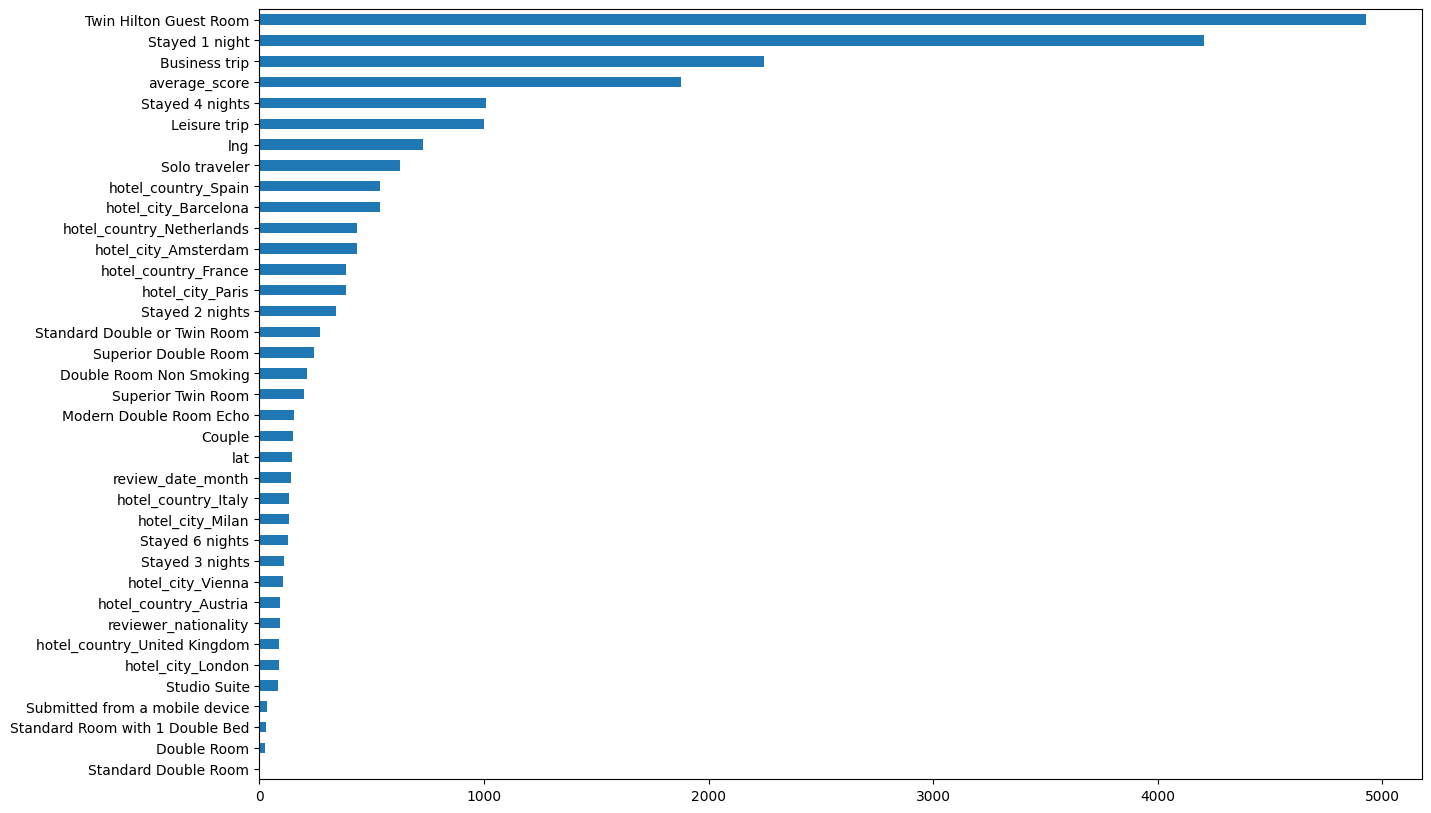

In [42]:
# для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат
# метод возвращает массив значений хи-квадрат и p-value для каждого признака
# используем только значения хи-квадрат и выведем их на графике:

from sklearn.feature_selection import chi2 # хи-квадрат

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

X['lng_'] = X['lng'] - X['lng'].min()
X = X.drop(['lng'], axis=1)

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

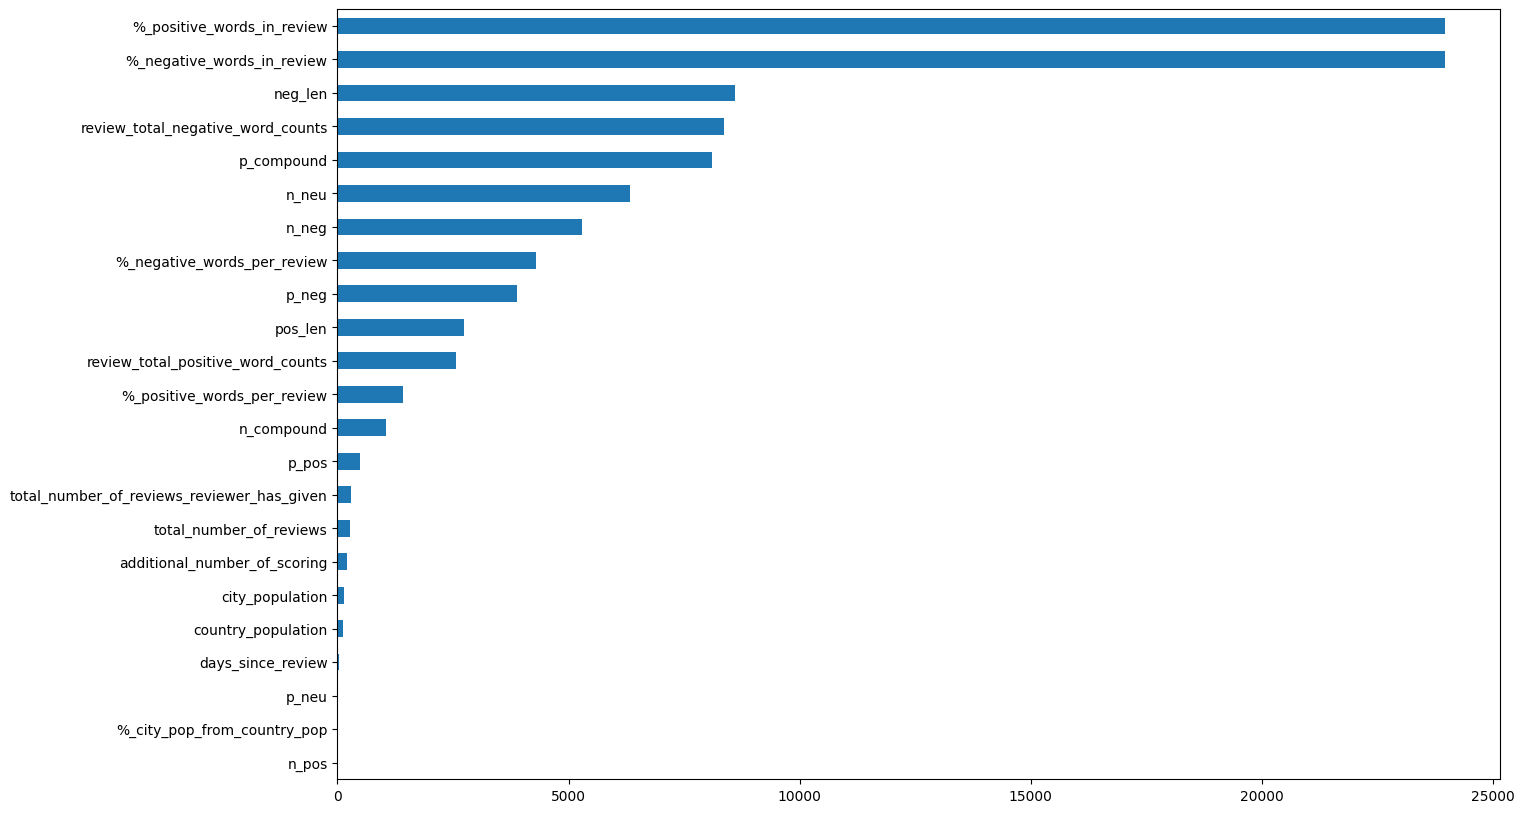

In [43]:
# для оценки значимости непрерывных переменных будем использовать функцию f_classif
# метод возвращает двумерный массив f-статистик и p-value для каждого признака
# в качестве меры значимости мы будем использовать значение f-статистики:

from sklearn.feature_selection import f_classif # anova

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

##### Для исключения мультиколлениарности удалим признаки с сильной корреляцией

In [44]:
# исключим мультиколлениарность и удалим признаки с сильной корреляцией

pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.74 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')
fig = px.imshow(pivot)
fig.show()

# постараемся удалить минимальное количество признаков

counter = 0
for lower_bound in np.linspace(0.98, 0.74, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = data.drop(col, axis=1)
            counter += 1
print('Deleted', counter, 'columns')

Deleted 14 columns


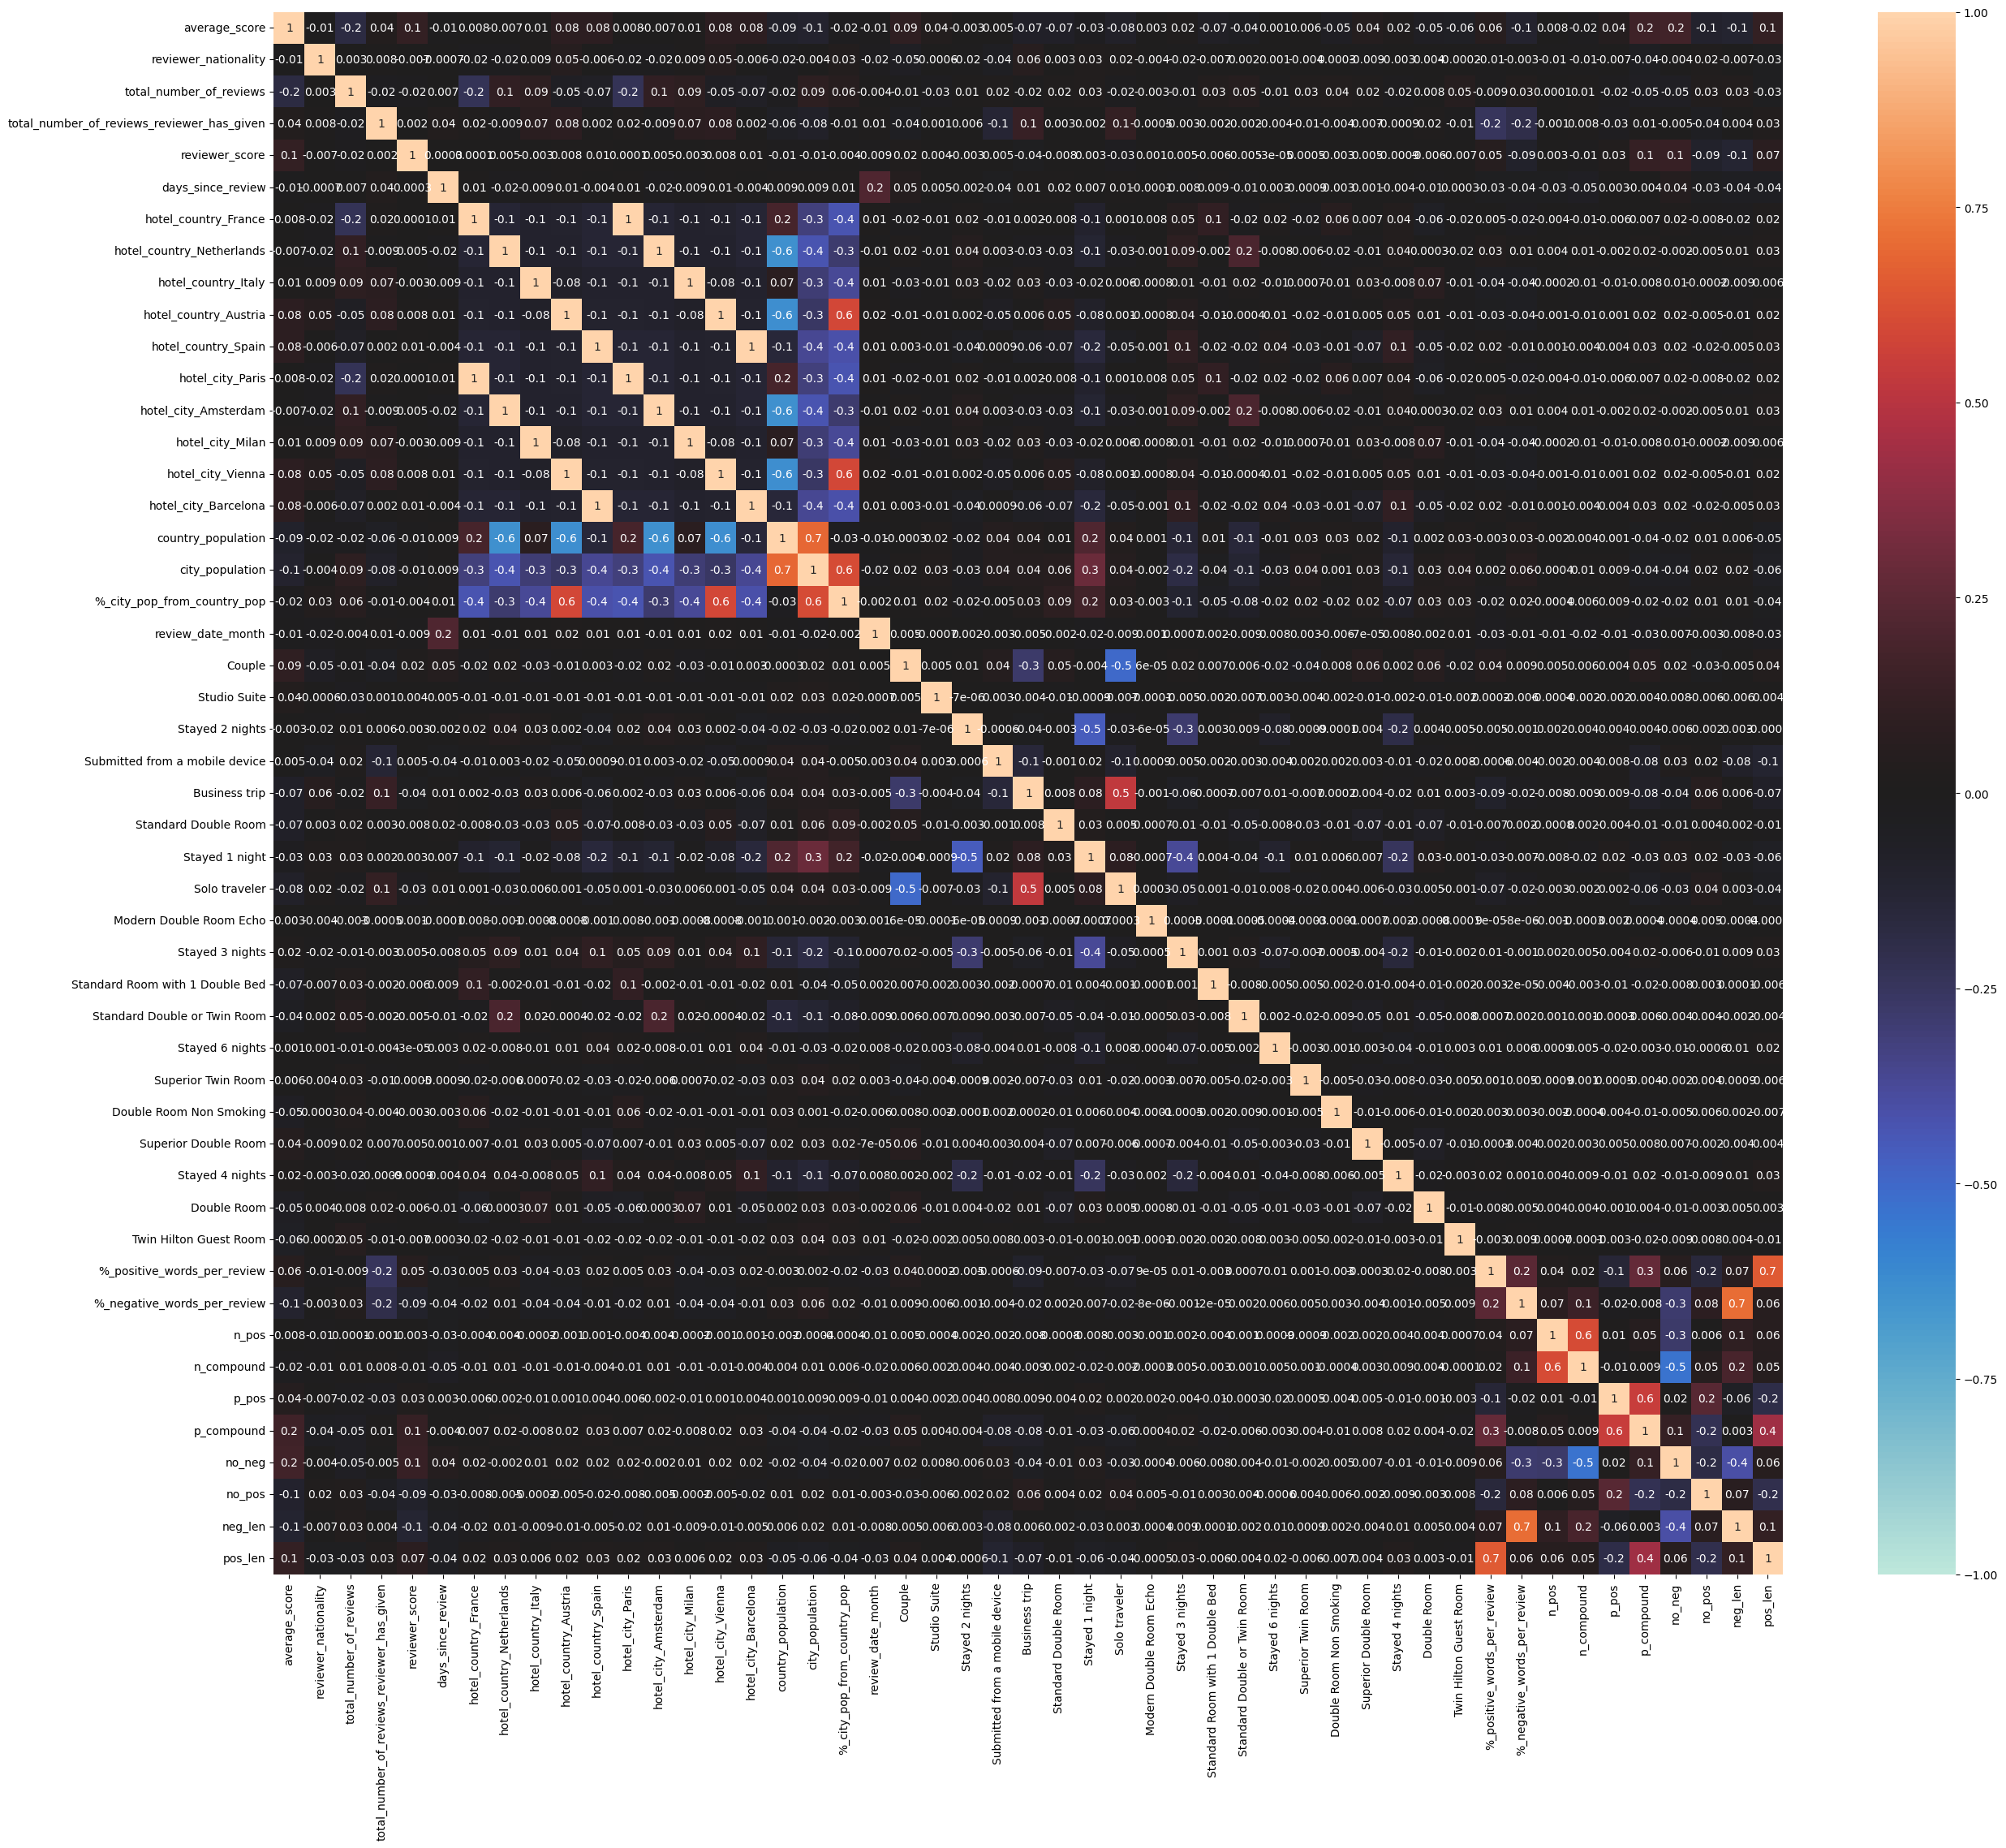

In [45]:
# выведем тепловую карту корреляции

plt.rcParams['figure.figsize'] = (30,25)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True, vmin=-1, vmax=1, center= 0, fmt='.1g');

##### От сильно коррелирующих признаков датасет почищен.

#### Подготовим данные для модели

In [46]:
# выделим из датасета тестовую часть

train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [47]:
# при помощи train_test_split для разбивки тестовых данных
# разделяем тренинговый датасет: 80% на обучение, 20% на валидацию

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [48]:
# проверяем данные

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 49), (386803, 49), (386803, 48), (309442, 48), (77361, 48))

# Обучение модели

In [49]:
# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)

regr = RandomForestRegressor(
    n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_SEED)

In [50]:
# обучаем модель на тестовом наборе данных  

regr.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга отелей в тестовой выборке
# предсказанные значения записываем в переменную y_pred

y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished


In [51]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test)
# метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную ошибку (в процентах) предсказанных значений 
# от фактических

mae_forest_regr = metrics.mean_absolute_error(y_test, y_pred).round(8)
mape_forest_regr = (metrics.mean_absolute_percentage_error(y_test, y_pred) * 100).round(8)
print(f'MAE: {mae_forest_regr}\nMAPE: {mape_forest_regr}')

MAE: 0.85744159
MAPE: 12.1850403


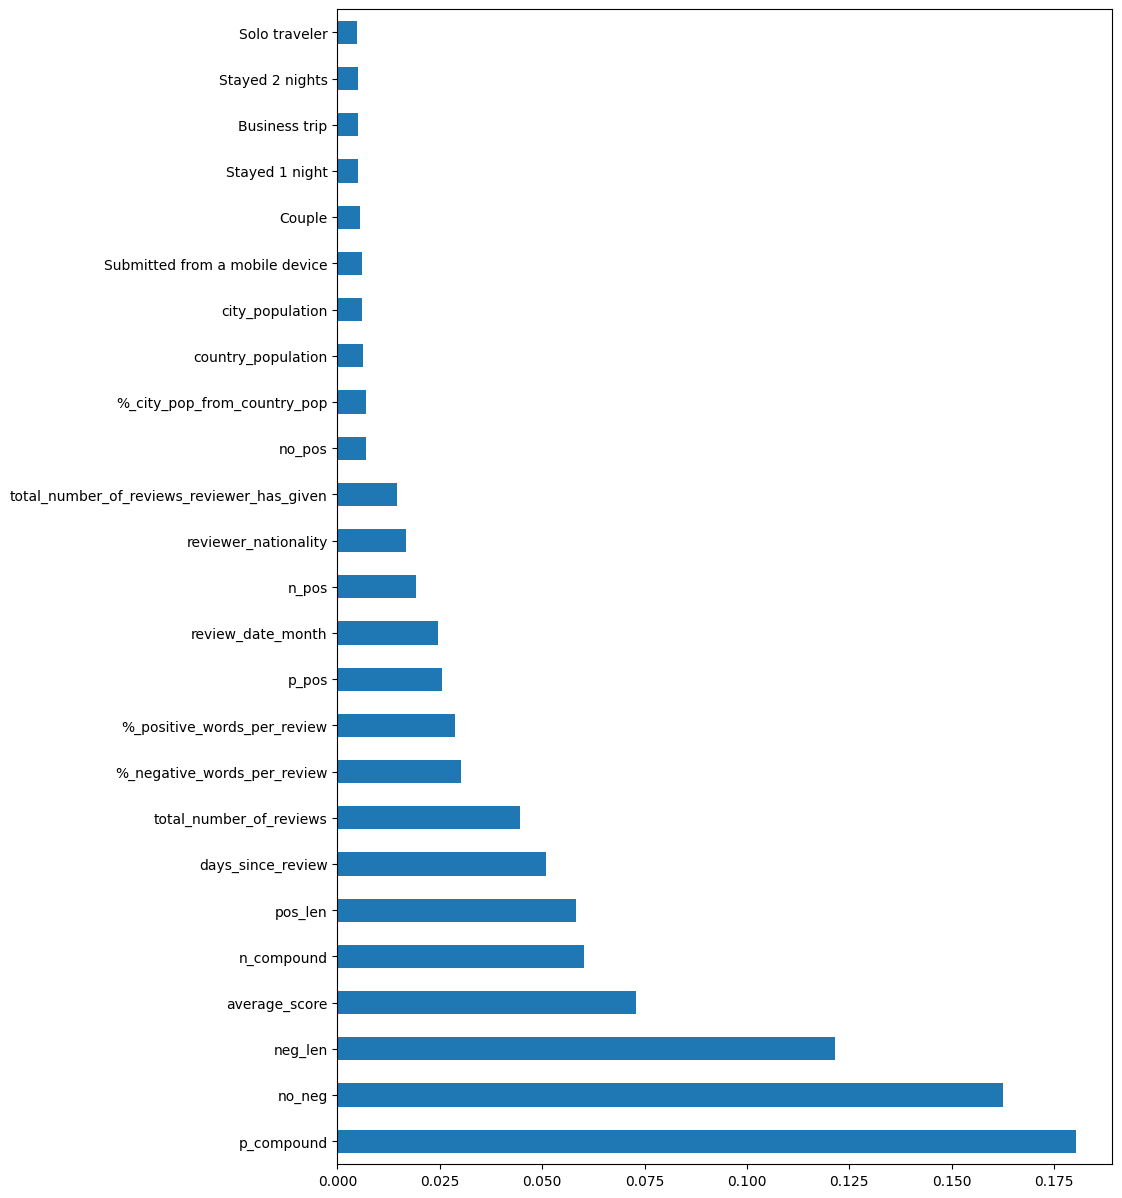

In [52]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10, 15)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh');

##### Предсказание целевой переменной

In [53]:
test_data.sample(5)

,average_score,reviewer_nationality,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,...,%_positive_words_per_review,%_negative_words_per_review,n_pos,n_compound,p_pos,p_compound,no_neg,no_pos,neg_len,pos_len
417371,8.9,0,1257,25,0.0,75,0,0,0,0,...,2.920000,0.080000,0.000,0.0000,0.206,0.9198,1,0,0,379
396277,9.3,10,1835,17,0.0,450,0,0,0,0,...,0.529412,0.000000,0.000,-0.7096,0.205,0.2023,1,0,0,51
466714,8.0,3,3633,1,0.0,392,0,0,0,0,...,23.000000,15.000000,0.241,0.3612,0.412,0.8979,0,0,73,129
393333,9.2,9,332,1,0.0,350,1,0,0,0,...,37.000000,3.000000,0.000,-0.5994,0.386,0.9516,1,0,0,202
458450,7.5,10,1016,7,0.0,261,0,0,0,0,...,1.857143,0.428571,0.000,0.0000,0.373,0.5467,0,0,16,73


In [54]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [55]:
sample_submission.head(10)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
5,10,302161
6,10,317079
7,1,13963
8,4,159785
9,10,195089


In [56]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


In [57]:
predict_submission

array([8.552, 7.093, 8.269, ..., 8.075, 9.578, 7.086])

In [58]:
list(sample_submission)

['reviewer_score', 'id']

In [59]:
sample_submission['reviewer_score'] = predict_submission

##### Сохрание результата (сабмишн для загрузки и оценки)

In [60]:
sample_submission.to_csv('submission.csv', index=False)

##### Посмотрим на результат

In [61]:
sample_submission.head(10)

,reviewer_score,id
0,8.552,488440
1,7.093,274649
2,8.269,374688
3,9.706,404352
4,9.481,451596
5,8.835,302161
6,7.636,317079
7,7.519,13963
8,8.799,159785
9,7.703,195089
